| [**Overview**](./00_overview.ipynb) |  **Examples:** |  [Selecting and Indexing Geochem Data](01_indexes_selectors.ipynb) | [Data Munging](02_munging.ipynb) | [Visualisation](03_visualisation.ipynb) |[lambdas](04_lambdas.ipynb) |
|:-----|:-----|:-----|:-----|:-----|:-----|

# lambdas: Parameterising REE Profiles


Orthogonal polynomial decomposition can be used for dimensional reduction of smooth
function over an independent variable, producing an array of independent values
representing the relative weights for each order of component polynomial. This is an
effective method to parameterise and compare the nature of smooth profiles.

In geochemistry, the most applicable use case is for reduction Rare Earth Element (REE)
profiles. The REE are a collection of elements with broadly similar physicochemical
properties (the lanthanides), which vary with ionic radii. Given their similar behaviour
and typically smooth function of normalised abundance vs. ionic radii, the REE profiles
and their shapes can be effectively parameterised and dimensionally reduced (14 elements
summarised by 3-4 shape parameters).

Here we generate some example data, reduce these to lambda values, and visualise the
results.


<div class='alert alert-success'> <b>Note:</b> this example is taken largely from the current pyrolite example for lambdas. As the next version is released, check back there for an updated example!</div>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyrolite.plot

np.random.seed(82)

First we'll generate some example **synthetic data** based around Depleted MORB Mantle:

In [2]:
from pyrolite.util.synthetic import example_spider_data

df = example_spider_data(
    noise_level=0.05,
    size=100,
    start="DM_SS2004",
    norm_to="ChondriteREE_ON",
    offsets={"Eu": 0.2},
)
df = df.pyrochem.denormalize_from("ChondriteREE_ON") # start with unnormalised data!

Let's have a quick look at what this REE data looks like normalized to Primitive
Mantle:




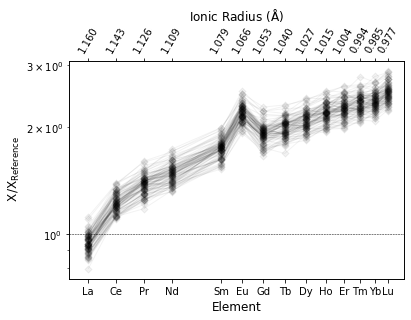

In [3]:
df.pyrochem.normalize_to("ChondriteREE_ON").pyroplot.REE(alpha=0.05, c="k", unity_line=True)
plt.show()

From this REE data we can fit a series of orthogonal polynomials, and subsequently used
the regression coefficients ('lambdas') as a parameterisation of the REE
pattern/profile:




In [4]:
ls = df.pyrochem.lambda_lnREE(degree=4)
ls.head(2)

,λ0,λ1,λ2,λ3
0,0.652374,-4.611939,-16.025599,-186.017395
1,0.608063,-4.768888,-19.576269,-181.549484


So what's actually happening here? To get some idea of what these λ coefficients
correspond to, we can pull this process apart and visualise our REE profiles as
the sum of the series of orthogonal polynomial components of increasing order.
As lambdas represent the coefficients for the regression of log-transformed normalised
data, to compare the polynomial components and our REE profile we'll first need to
normalize it to the appropriate composition (here `"ChondriteREE_ON"`) before
taking the logarithm.

With our data, we've then fit a function of ionic radius with the form
$f(r) = \lambda_0 + \lambda_1 f_1 + \lambda_2 f_2 + \lambda_3 f_3...$
where the polynomial components of increasing order are $f_1 = (r - \beta_0)$,
$f_2 = (r - \gamma_0)(r - \gamma_1)$,
$f_3 = (r - \delta_0)(r - \delta_1)(r - \delta_2)$ and so on. The parameters
$\beta$, $\gamma$, $\delta$ are pre-computed such that the
polynomial components are indeed independent. Here we can visualise how these
polynomial components are summed to produce the regressed profile, using the last REE
profile we generated above as an example:




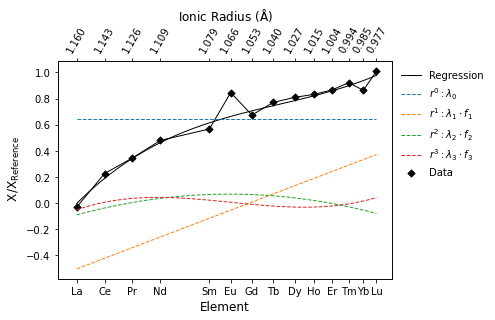

In [5]:
from pyrolite.util.lambdas.plot import plot_lambdas_components

ax = (
    df.pyrochem.normalize_to("ChondriteREE_ON")
    .iloc[-1, :]
    .apply(np.log)
    .pyroplot.REE(color="k", label="Data", logy=False)
)

plot_lambdas_components(ls.iloc[-1, :], ax=ax)

ax.legend()
plt.show()

Now that we've gone through a brief introduction to how the lambdas are generated,
let's quickly check what the coefficient values themselves look like:




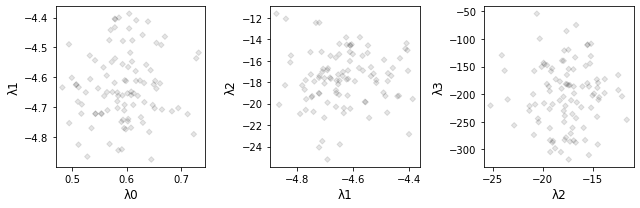

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for ix in range(ls.columns.size - 1):
    ls[ls.columns[ix : ix + 2]].pyroplot.scatter(ax=ax[ix], alpha=0.1, c="k")

plt.tight_layout()

But what do these parameters correspond to? From the deconstructed orthogonal
polynomial above, we can see that $\lambda_0$ parameterises relative enrichment
(this is the mean value of the logarithm of Chondrite-normalised REE abundances),
$\lambda_1$ parameterises a linear slope (here, LREE enrichment), and higher
order terms describe curvature of the REE pattern. Through this parameterisation,
the REE profile can be effectively described and directly linked to geochemical
processes. While the amount of data we need to describe the patterns is lessened,
the values themselves are more meaningful and readily used to describe the profiles
and their physical significance.

The visualisation of $\lambda_1$-$\lambda_2$ can be particularly useful
where you're trying to compare REE profiles.

We've used a synthetic dataset here which is by design approximately normally
distributed, so the values themeselves here are not particularly revealing,
but they do illustrate the expected mangitudes of values for each of the parameters.




## Dealing With Anomalies
Note that we've not used Eu in this regression - Eu anomalies are a deviation from
the 'smooth profile' we need to use this method. Consider this if your data might also
exhibit significant Ce anomalies, you might need to exclude this data. For convenience
there is also functionality to calculate anomalies derived from the orthogonal
polynomial fit itself (rather than linear interpolation methods). Below we use the
`anomalies` keyword argument to also calculate the $\frac{Ce}{Ce*}$
and $\frac{Eu}{Eu*}$ anomalies (note that these are excluded from the fit):




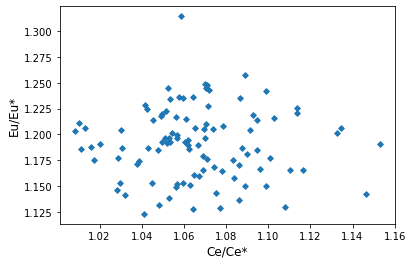

In [7]:
ls_anomalies = df.pyrochem.lambda_lnREE(anomalies=["Ce", "Eu"])
ax = ls_anomalies.iloc[:, -2:].pyroplot.scatter()
plt.show()

## Fitting Tetrads

In addition to fitting orothogonal polynomial functions, the ability to fit tetrad
functions has also recently been added. This supplements the $\lambda$
coefficients with $\tau$ coefficients which describe subtle electronic
configuration effects affecting sequential subsets of the REE. Below we plot four
profiles - each describing only a single tetrad - to illustrate the shape of
these function components. Note that these are functions of $z$, and are here
transformed to plot against radii.




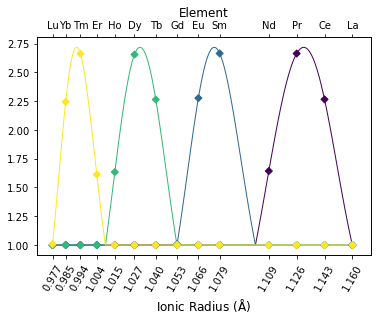

In [8]:
from pyrolite.util.lambdas.plot import plot_profiles

# let's first create some synthetic pattern parameters
# we want lambdas to be zero, and each of the tetrads to be shown in only one pattern
lambdas = np.zeros((4, 5))
tetrads = np.eye(4)
# putting it together to generate four sets of combined parameters
fit_parameters = np.hstack([lambdas, tetrads])

ax = plot_profiles(
    fit_parameters,
    tetrads=True,
    color=np.arange(4),
)
plt.show()

In order to also fit these function components, you can pass the keyword argument
`fit_tetrads=True` to `pyrolite.geochem.pyrochem.lambda_lnREE` and
related functions:




In [9]:
lts = df.pyrochem.lambda_lnREE(degree=4, fit_tetrads=True)

We can see that the four extra $\tau$ Parameters have been appended to the
right of the lambdas within the output:




In [10]:
lts.head(2)

,λ0,λ1,λ2,λ3,τ0,τ1,τ2,τ3
0,0.619539,-5.070743,-15.260098,-57.386414,0.116116,0.037515,0.023975,0.010200
1,0.585001,-5.525443,-19.733065,68.100464,0.169711,0.034378,-0.030892,-0.026678


Below we'll look at some of the potential issues of fitting lambdas and tetrads
together - by examining the effects of i) fitting tetrads where there are none
and ii) not fitting tetrads where they do indeed exist using some synthetic datasets.




In [11]:
from pyrolite.util.synthetic import example_patterns_from_parameters
from pyrolite.geochem.ind import REE


ls = np.array(
    [
        [2, 5, -30, 100, -600, 0, 0, 0, 0],  # lambda-only
        [3, 15, 30, 300, 1500, 0, 0, 0, 0],  # lambda-only
        [1, 5, -50, 0, -1000, -0.3, -0.7, -1.4, -0.2],  # W-pattern tetrad
        [5, 15, 50, 400, 2000, 0.6, 1.1, 1.5, 0.3],  # M-pattern tetrad
    ]
)
# now we use these parameters to generate some synthetic log-scaled normalised REE
# patterns and add a bit of noise
pattern_df = pd.DataFrame(
    np.vstack([example_patterns_from_parameters(l, includes_tetrads=True) for l in ls]),
    columns=REE(),
)
# We can now fit these patterns and see what the effect of fitting and not-Fitting
# tetrads might look like in these (slightly extreme) cases:
fit_ls_only = pattern_df.pyrochem.lambda_lnREE(
    norm_to=None, degree=5, fit_tetrads=False
)
fit_ts = pattern_df.pyrochem.lambda_lnREE(norm_to=None, degree=5, fit_tetrads=True)

We can now examine what the differences between the fits are. Below we plot the four
sets of synthetic REE patterns (lambda-only above and lamba+tetrad below) and examine
the relative accuracy of fitting some of the higher order lambda parameters where
tetrads are also fit:




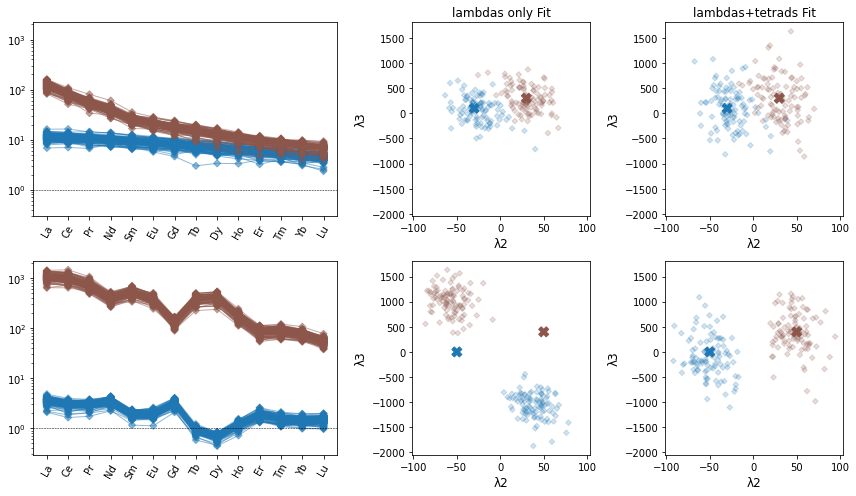

In [12]:
from pyrolite.util.plot.axes import share_axes

x, y = 2, 3
categories = np.repeat(np.arange(ls.shape[0]), 100)
colors = np.array([str(ix) * 2 for ix in categories])
l_only = categories < 2

ax = plt.figure(figsize=(12, 7)).subplot_mosaic(
    """
    AAABBCC
    DDDEEFF
    """
)
share_axes([ax["A"], ax["D"]])
share_axes([ax["B"], ax["C"], ax["E"], ax["F"]])

ax["B"].set_title("lambdas only Fit")
ax["C"].set_title("lambdas+tetrads Fit")


for a, fltr in zip(["A", "D"], [l_only, ~l_only]):
    pattern_df.iloc[fltr, :].pyroplot.spider(
        ax=ax[a],
        label="True",
        unity_line=True,
        alpha=0.5,
        color=colors[fltr],
    )

for a, fltr in zip(["B", "E"], [l_only, ~l_only]):
    fit_ls_only.iloc[fltr, [x, y]].pyroplot.scatter(
        ax=ax[a],
        alpha=0.2,
        color=colors[fltr],
    )

for a, fltr in zip(["C", "F"], [l_only, ~l_only]):
    fit_ts.iloc[fltr, [x, y]].pyroplot.scatter(
        ax=ax[a],
        alpha=0.2,
        color=colors[fltr],
    )


true = pd.DataFrame(ls[:, [x, y]], columns=[fit_ls_only.columns[ix] for ix in [x, y]])
for ix, a in enumerate(["B", "C", "E", "F"]):
    true.iloc[np.array([ix < 2, ix < 2, ix >= 2, ix >= 2]), :].pyroplot.scatter(
        ax=ax[a],
        color=np.array([str(ix) * 2 for ix in np.arange(ls.shape[0 ]// 2)]),
        marker="X",
        s=100,
    )

plt.tight_layout()
plt.show()